# Face Mask Detection


The objective is to anticipate and outline the boundaries (mask) surrounding the face within a provided image.


• **DOMAIN**: Entertainment

• **CONTEXT**: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

• **DATA DESCRIPTION**: The dataset comprises of images and its mask for corresponding human face.

• **PROJECT OBJECTIVE**: To build a face detection system.

In [1]:
 # Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Setting the current working directory
import os; os.chdir("/content/gdrive/MyDrive/Education/GL_Data/Computer_Vision_Face_Recognition")

In [5]:
# Imports the packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [6]:
!ls

'Benedict Cumberbatch9.jpg'    'images (3).npy'    'training_images-20211126T092819Z-001 (1).zip'
'Dwayne Johnson4.jpg'	       'Martin Starr.zip'   vgg_face_weights.h5
'Hint - CV - 2_Part 2_.ipynb'   PINS.zip


In [7]:
#Importing the Images.npy

#Reference: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
#This file contains images with details of bounding boxes
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

Data = np.load('images (3).npy')

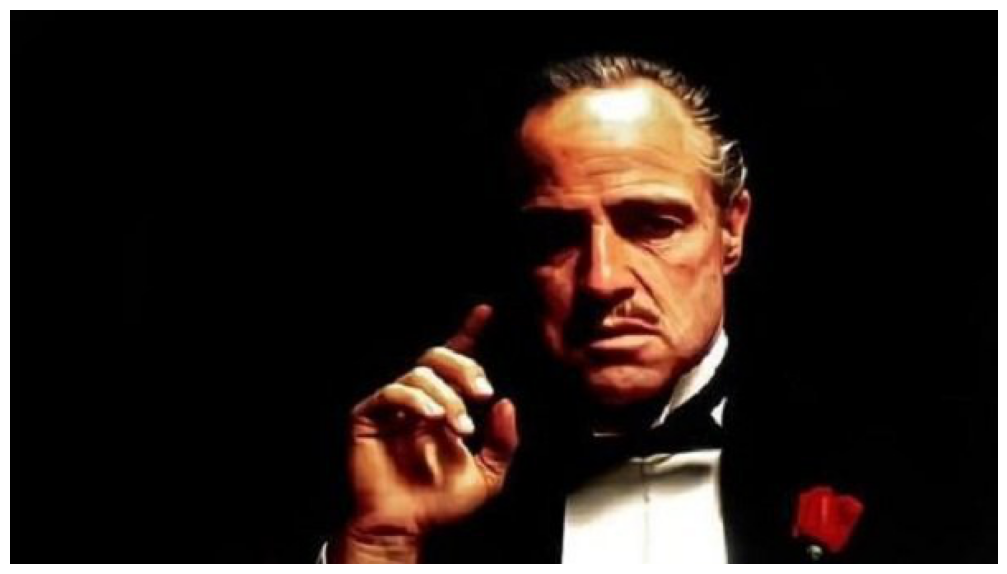

In [8]:
#below code for Sample image from dataset
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(Data[10][0])
plt.show()

In [9]:
#Defining image dimensions
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### **Generate features and labels as follows:**
- Features: The images serve as the features.
- Labels: The masks represent the labels.
- Store the images in the 'X' array.
- Save the masks in the 'masks' array.

In [10]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [11]:
X.shape

(409, 224, 224, 3)

In [12]:
masks.shape

(409, 224, 224)

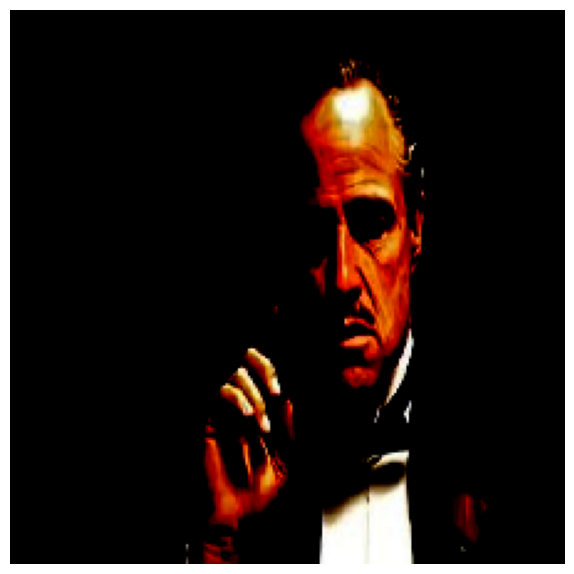

In [13]:
### Print a sample image and image array
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

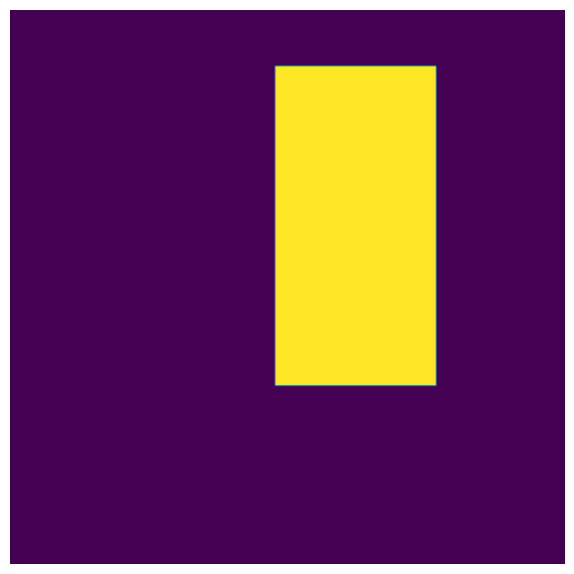

In [14]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

##  Model Creation
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: 'imagenet'
- Add UNET architecture layers

In [15]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output

    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)

    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [16]:
model = create_model(True)
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           

### Define Dice Coefficient Calculation Function
- Develop a function to compute the Dice coefficient.


In [17]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Defining the loss

In [18]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Model Compilation
Compile the model using the following parameters:
  - Loss: Utilize the defined loss function.
  - Optimizer: Implement the Adam optimizer.
  - Metrics: Apply the dice_coefficient function defined earlier.

In [48]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

In [50]:
### Define checkpoint and earlystopping
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', save_freq = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

### Model Fitting
Train the model using the following parameters:
  - Epochs: To be determined
  - Batch size: 1
  - Callbacks: checkpoint, reduce_lr, stop

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size = 0.15, random_state = 2019, shuffle = False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((347, 224, 224, 3), (62, 224, 224, 3), (347, 224, 224), (62, 224, 224))

In [52]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Streaming output truncated to the last 5000 lines.
284/347 [=======================>......] - ETA: 15s - loss: 0.1580 - dice_coefficient: 0.9287
Epoch 23: loss did not improve from 0.04823
285/347 [=======================>......] - ETA: 14s - loss: 0.1577 - dice_coefficient: 0.9287
Epoch 23: loss did not improve from 0.04823
286/347 [=======================>......] - ETA: 14s - loss: 0.1574 - dice_coefficient: 0.9288
Epoch 23: loss did not improve from 0.04823
287/347 [=======================>......] - ETA: 14s - loss: 0.1570 - dice_coefficient: 0.9290
Epoch 23: loss did not improve from 0.04823
288/347 [=======================>......] - ETA: 14s - loss: 0.1569 - dice_coefficient: 0.9290
Epoch 23: loss did not improve from 0.04823
289/347 [=======================>......] - ETA: 13s - loss: 0.1565 - dice_coefficient: 0.9291
Epoch 23: loss did not improve from 0.04823
290/347 [========================>.....] - ETA: 13s - loss: 0.1561 - dice_coefficient: 0.9293
Epoch 23: loss did not impr

In [55]:
model.evaluate(X_valid, y_valid, verbose = 1)

2/2 [==============================] - 1s 331ms/step - loss: 0.8825 - dice_coefficient: 0.6428


[0.8825494050979614, 0.6427783966064453]

In [58]:
### Obtain the predicted mask for a sample image.
# Load previous model weight
WEIGHTS_FILE = "model_2.21.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)

2/2 [==============================] - 0s 258ms/step


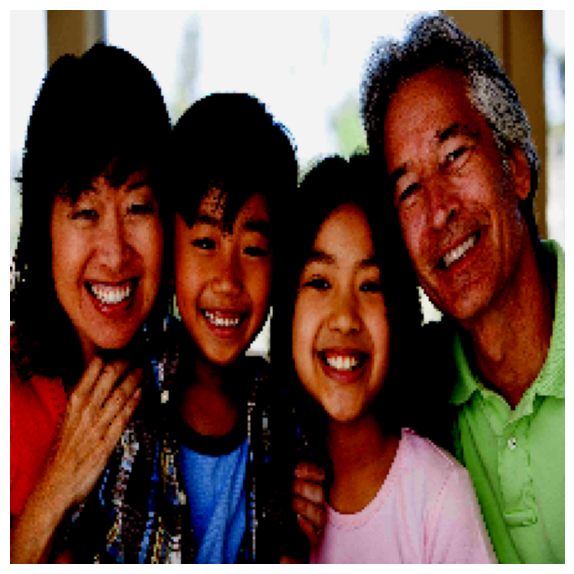

In [59]:
# Below code is For a sample image
n = 16
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

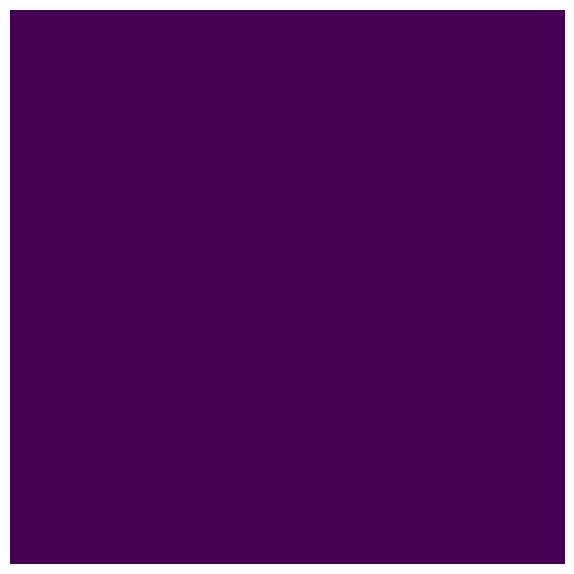

In [60]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

### Imposing the mask on the image

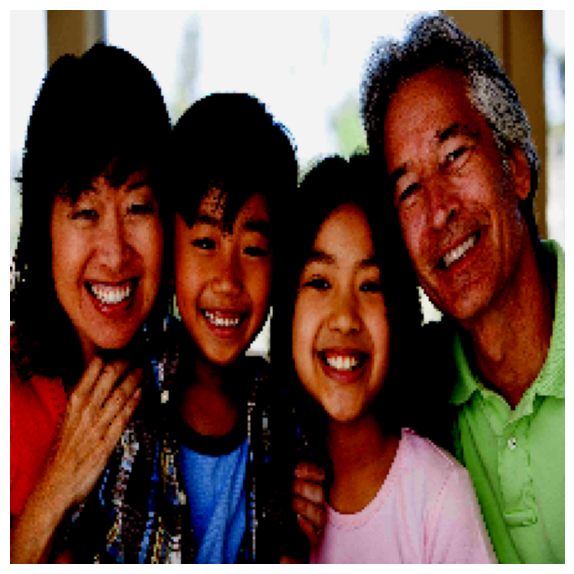

In [61]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

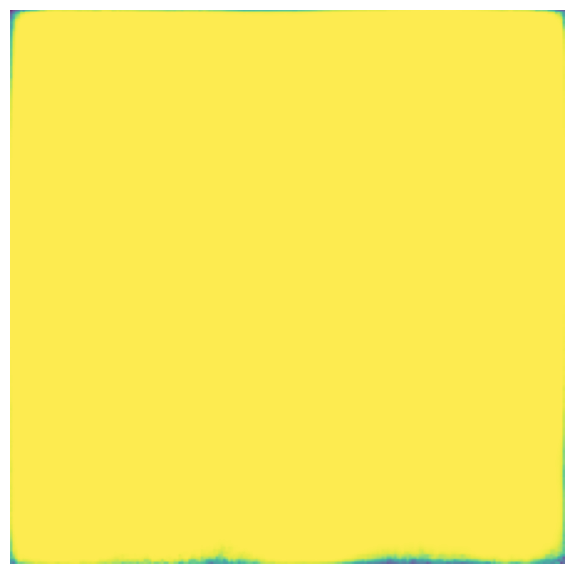

In [62]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

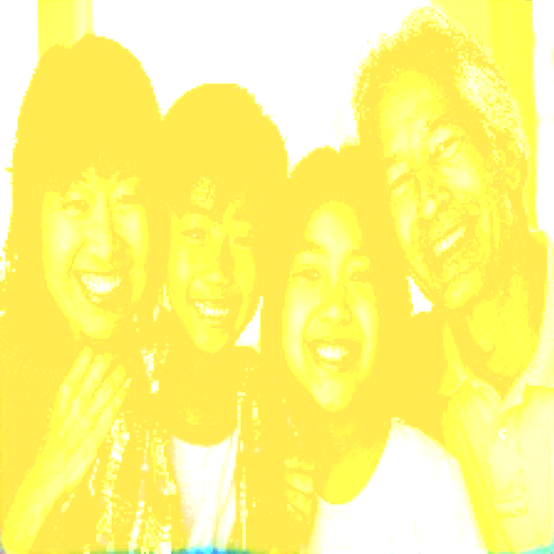

In [63]:
from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)

### inference
The project focused on leveraging a pre-trained MobileNet model through transfer learning, augmenting it with UNET layers to train, fit, and evaluate a model aimed at predicting the boundaries (mask) around faces in given images.
* The model was compiled using binary cross-entropy as the loss function, Adam optimizer, and Dice coefficient as the metric for evaluation.
* To enhance training and monitoring, callbacks such as Model Checkpoint, Early Stopping, and Learning Rate Reducers were implemented.
* The dataset was divided into training and validation sets using an 85/15 ratio. The model achieved a best loss of 0.10 and a Dice coefficient of 0.95 on the training data.
* The trained model weights were utilized to predict masks on the validation dataset.
* Additionally, a sample image was selected for visualization, and the predicted mask was overlaid onto the image.
* As observed from the results, the model demonstrated high accuracy in predicting the masks, as evidenced by the visual comparison.

This comprehensive approach highlights the effectiveness of combining pre-trained models with customized architectures for accurate mask prediction in facial image analysis tasks.
